In [63]:
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
from torch.nn.utils import clip_grad_norm_
import time
import matplotlib.pyplot as plt

In [10]:
from math import sqrt
def get_norm(model):
    total_norm_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            # p.grad.data.norm(2) returns a tensor, .item() gets the Python float
            param_norm = p.grad.data.norm(2).item()
            total_norm_sq += param_norm ** 2
    return sqrt(total_norm_sq)

In [81]:
def plot_two_metrics(metric1, metric2, label1='Loss', label2='Gradient Norm'):
    """
    Plot two lists on the same figure.

    Args:
        metric1 (list of float): First metric values.
        metric2 (list of float): Second metric values.
        label1 (str): Label for the first metric.
        label2 (str): Label for the second metric.
    """
    plt.figure()
    plt.plot(metric1, label=label1)
    plt.plot(metric2, label=label2)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Metrics Over Iterations')
    plt.legend()
    plt.show()

# If you don't already have it, define get_norm(model):
def get_norm(model):
    total_norm_sq = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm_sq += p.grad.data.norm(2).item() ** 2
    return total_norm_sq ** 0.5


In [12]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set  = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
                             ]))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=4)


# Dataloading
subset_size  = int(0.002 * len(train_set))
rest_size    = len(train_set) - subset_size
small_train, _ = random_split(train_set, [subset_size, rest_size])

small_loader = DataLoader(
    small_train,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    persistent_workers=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [14]:
len(small_loader)

1

In [124]:
class VADAM(Optimizer):
    """
    Velocity-Adaptive Momentum (VAM) optimizer with Adam-like behavior and weight decay according to ADAMW
    """
    def __init__(self, params, beta1= 0.9, beta2= 0.999, beta3= 1, mass= 10, eps=1e-8, weight_decay=0, power=2):
        defaults= dict(beta1 = beta1, beta2= beta2, beta3= beta3, mass=mass, eps = eps, weight_decay= weight_decay, power=power)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None

        for group in self.param_groups:
            beta1= group['beta1']
            beta2= group['beta2']
            beta3= group['beta3']
            mass = group['mass']
            eps = group['eps']
            wd= group['weight_decay']
            power= group['power']

            # get velocity and second moment terms
            total_sq_norm = 0.0
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad

                state= self.state[p]
                buf_vel= state.get('momentum_buffer', None)
                if buf_vel is None:
                    buf_vel = torch.zeros_like(p)
                    state['momentum_buffer'] = buf_vel
                buf_vel.mul_(beta1).add_(d_p, alpha=1- beta1)
                total_sq_norm += float(buf_vel.abs().pow(power).sum())

                buf_sec_mom= state.get('sec_momentum_buffer', None)
                if buf_sec_mom is None:
                    buf_sec_mom = torch.zeros_like(p)
                    state['sec_momentum_buffer'] = buf_sec_mom
                buf_sec_mom.mul_(beta2).addcmul_(d_p, d_p, value=1 - beta2)


                _t= state.get('step', None)
                if _t is None:
                    state['step'] = 0
                state['step'] += 1
                t= state['step']



            lr= 1/(mass + beta3 * total_sq_norm)
            print(f"total_sq_norm: {total_sq_norm}")
            for p in group['params']:
                if p.grad is None:
                    continue
                buf_vel= self.state[p]['momentum_buffer']
                buf_sec_mom= self.state[p]['sec_momentum_buffer']

                # could be done more efficiently in place
                # rescale  velocity and second moment terms
                tmp1= buf_vel.div(1- beta1**t)
                tmp2= buf_sec_mom.div(1- beta2**t)

                tmp2.sqrt_().add_(eps)
                tmp1.div_(tmp2)

                # update parameter with weight decay
                p.mul_(1-wd*lr).add_(tmp1, alpha=-lr)
        return loss
    
    #if wd != 0:
    #    d_p = d_p.add(p, alpha=wd)

In [125]:
model= SimpleCNN().to(device)

In [128]:
#optim_params= dict(lr=0.1, momentum=0.9, weight_decay=5e-4)
#optimizer= optim.SGD(model.parameters(),**optim_params)

model= SimpleCNN().to(device)
optim_params= dict(beta1=0.9, beta2=0.999, mass=1000, beta3=1000,eps=1e-8, weight_decay=5e-4, power=2)
optimizer= VADAM(model.parameters(), **optim_params)


2.3002305030822754
total_sq_norm: 0.007125423873560521
2.233464479446411
total_sq_norm: 0.011051227551661214
2.2080342769622803
total_sq_norm: 0.017050401231244905
2.120748519897461
total_sq_norm: 0.024469393696563202
2.0525546073913574
total_sq_norm: 0.031825500023842324
1.9665554761886597
total_sq_norm: 0.04719019118601864
1.8665361404418945
total_sq_norm: 0.060163696340168826
1.8422430753707886
total_sq_norm: 0.07596705090691103
1.7245118618011475
total_sq_norm: 0.09101649712101789
1.7214311361312866
total_sq_norm: 0.1003612786589656
1.7054356336593628
total_sq_norm: 0.11958223813780933
1.608349323272705
total_sq_norm: 0.11929899518872844
1.5853554010391235
total_sq_norm: 0.13526972130057402
1.582078218460083
total_sq_norm: 0.1301730440936808
1.506630301475525
total_sq_norm: 0.14409462975163478
1.5343669652938843
total_sq_norm: 0.15877299489511643
1.5350993871688843
total_sq_norm: 0.19589006342721405
1.3472621440887451
total_sq_norm: 0.19346588056214387
1.32817804813385
total_sq_nor

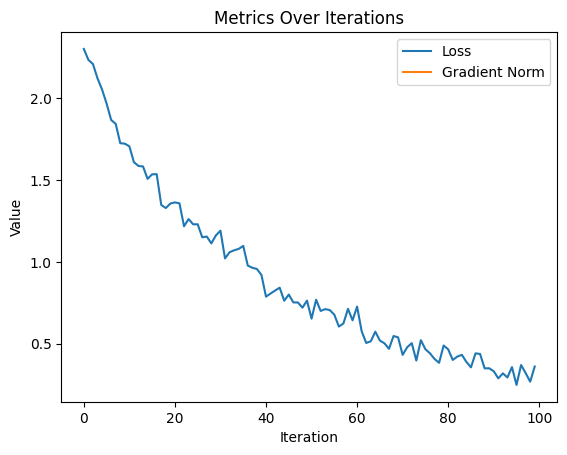

Final Loss: 0.360118567943573


In [129]:
losses = []
norms  = []

for epoch in range(100):
    for inputs, targets in small_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        print(loss.item())
        # record metrics before the step
        losses.append(loss.item())
        #norms.append(get_norm(model))
        optimizer.step()


plot_two_metrics(losses, norms, label1='Loss', label2='Gradient Norm')

print("Final Loss:", losses[-1])



In [130]:
model2= SimpleCNN().to(device)
optim_params= dict(lr= 0.005, weight_decay=5e-4)
optimizer2= optim.AdamW(model2.parameters(), **optim_params)



Final Loss (model2): 0.1781


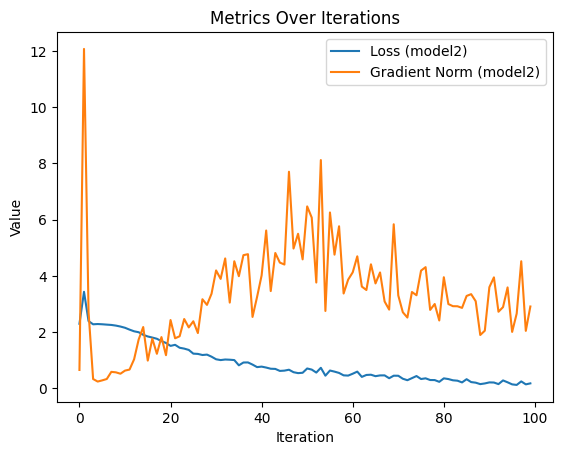

In [131]:
losses2 = []
norms2  = []

for epoch in range(100):
    for inputs, targets in small_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # record
        losses2.append(loss.item())
        norms2.append(get_norm(model2))
        
        optimizer2.step()

# print final loss
print(f"Final Loss (model2): {losses2[-1]:.4f}")

plot_two_metrics(losses2, norms2, label1='Loss (model2)', label2='Gradient Norm (model2)')
